## How to call immune subtypes on new data ##

Let's suppose you have some:
  a.) RPKM (or FPKM or something equivlent) gene expression data 
  b.) Has hg19 gene symbols mapped to it.
  c.) knowledge on how to batch correct / normalize it with regard to TCGA PanCancer data*
  
and you'd like to call some immune subtypes on those samples.

In [40]:
library(ggplot2)
library(clue)
library(mclust)
library(parallel)
library(stringr)
options(repr.plot.width=4, repr.plot.height=3)

Package 'mclust' version 5.4.2
Type 'citation("mclust")' for citing this R package in publications.

Attaching package: ‘mclust’

The following object is masked from ‘package:mgcv’:

    mvn



## Read in the data 

In [2]:
#loading TCGA PanCancer EB++ expression data, subset to the pertinent genes.
tcgaSubset <- read.table('../shiny-app/Immune-Subtype-Clustering/data/ebppSubset.tsv.bz2', header = T, sep = '\t', stringsAsFactors = F)

dim(tcgaSubset)

[1] 2316 9129


In [3]:
# bring in the new data #
# found some RPKM RNA-seq data
# 
newDat <- read.table('../ExtraData/ebpp_test1_1to20.tsv', sep='\t', header=T, stringsAsFactors = F)

dim(newDat)

[1] 20531    21

In [4]:
# these are the scores from the manuscript
reportedScores <- read.table('../shiny-app/Immune-Subtype-Clustering//data//five_signature_mclust_ensemble_results.tsv.gz', sep='\t', header=T, stringsAsFactors = F)

# then make the rownames the aliquot barcodes to match up with TCGA calls
rownames(reportedScores) <- reportedScores$AliquotBarcode

In [5]:
# all the genes we need for the 5 signatures
load('../shiny-app/Immune-Subtype-Clustering/data/comparative_immuneSigs_geneLists4.rda')

# and we use the scoring code to produce scores #
source('../shiny-app/Immune-Subtype-Clustering/src/ImmuneSigs68_function.R')

In [6]:
# code for calling the clusters using pre-trained models
source('../shiny-app/Immune-Subtype-Clustering/src/signature_mclust_ensemble.R')

# the models trained on TCGA data #
load('../shiny-app/Immune-Subtype-Clustering/data/wolf_set_slim1.rda')

# Z-score the signatures before feeding to models.
zscore.cols2<-function(x){
    return((apply(x, 2, function(x) (x - median(na.omit(x)))/sd(na.omit(x)))))
}    

In [7]:
# load the clustering model trained on all pancan data.

load("../shiny-app/Immune-Subtype-Clustering//data/wolf_set_slim1.rda")

Package 'mclust' version 5.4.2
Type 'citation("mclust")' for citing this R package in publications.


## Data prep

In [8]:
# tcga data is already upper quantile normalized
tcgaSubset <- log2(tcgaSubset + 1)

In [9]:
# here we'll drop any duplicate genes, and make the rownames
# be gene symbols
rownames(newDat) <- newDat$GeneID
didx <- !duplicated(as.character(rownames(newDat)))
dat <- newDat[didx,-1]

# TCGA data was upper quantile normalized (at the 75%) and multiplied by 1000
data.quantileExpressed <- apply(dat, 2, function(x){quantile(x[x>0], 0.75)})
datnorm <- as.data.frame(t( t(dat) / data.quantileExpressed ) ) * 1000

# and logged.
datlog2 <- log2(datnorm+1)

dim(datlog2)

[1] 20531    20

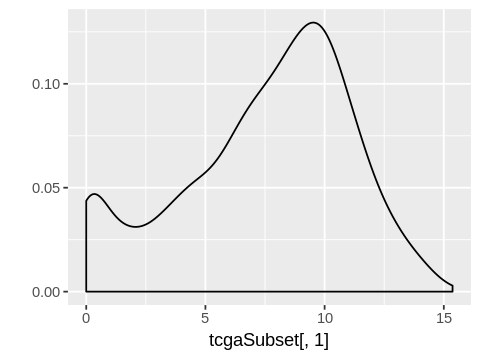

In [10]:
# look at the tcga distribution
qplot(tcgaSubset[,1], geom='density')

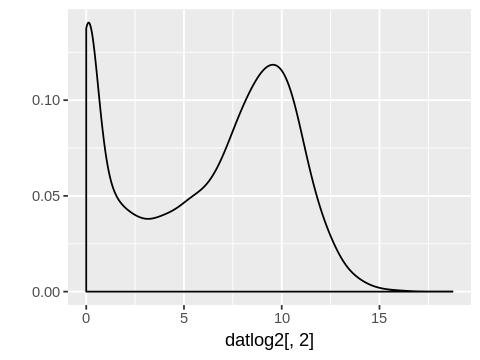

In [11]:
# check distribution of the data

qplot(datlog2[,2], geom='density')

In [12]:
# clean up
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,876301,46.8,3896413,208.1,8591118,458.9
Vcells,42623379,325.2,110942046,846.5,110940795,846.5


## Joining the data

In [13]:
### joining data sets ###
sharedGenes  <- intersect(rownames(tcgaSubset), rownames(datlog2))

# first median scale each data set
newDatSub    <- datlog2[sharedGenes,]

# getting things in the right order
tcgaSubsetSub <- tcgaSubset[sharedGenes,]

# then join the new data and tcga data at the genes
joinDat <- cbind(newDatSub, tcgaSubsetSub)

dim(joinDat)

[1] 2316 9149

## Batch correcting the data

In [14]:
# pre-batch corrected table, for plotting
newdatSamples <- colnames(newDatSub)
dat2idx <- 1:(ncol(newDatSub)-1)
tcgaidx <- setdiff( (1: (ncol(joinDat)-1)), dat2idx)

sampleIdx <- c(dat2idx, sample(tcgaidx, size=200, replace = F))
preCombat <- joinDat[,sampleIdx]
preCombatMelt <- reshape2::melt(preCombat)
preCombatMelt$SampleSource <- ifelse(test = preCombatMelt$variable %in% newdatSamples, yes = "New Data", no="TCGA Data")



No id variables; using all as measure variables


In [15]:

# batch correction #

library(sva)
combatflag <- 0

if (combatflag) {
    # then batch correction between scores...
    batch <- c(rep(1,ncol(newDatSub)), rep(2,ncol(tcgaSubsetSub)))
    modcombat = model.matrix(~1, data=as.data.frame(t(joinDat)))
    combat_edata = ComBat(dat=joinDat, batch=batch, mod=modcombat, 
                          par.prior=TRUE, prior.plots=FALSE, ref.batch = 2)
} else {
    combat_edata = joinDat    
}


Loading required package: mgcv
Loading required package: nlme
This is mgcv 1.8-27. For overview type 'help("mgcv-package")'.

Attaching package: ‘mgcv’

The following object is masked from ‘package:mclust’:

    mvn

Loading required package: genefilter
Loading required package: BiocParallel


In [16]:
# then look at the distribution of the data after batch correction
postCombat <- combat_edata[,sampleIdx]
postCombatMelt <- reshape2::melt(postCombat)
postCombatMelt$SampleSource <- ifelse(test = postCombatMelt$variable %in% newdatSamples, yes = "New Data", no="TCGA Data")


No id variables; using all as measure variables


Warning message:
“Removed 1066 rows containing non-finite values (stat_density).”

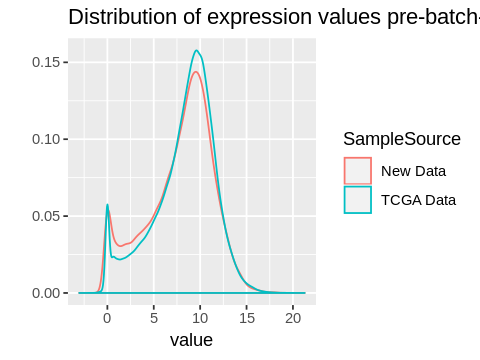

In [17]:
qplot(data=preCombatMelt, col=SampleSource, x=value, geom='density', main = 'Distribution of expression values pre-batch-correction')

Warning message:
“Removed 1066 rows containing non-finite values (stat_density).”

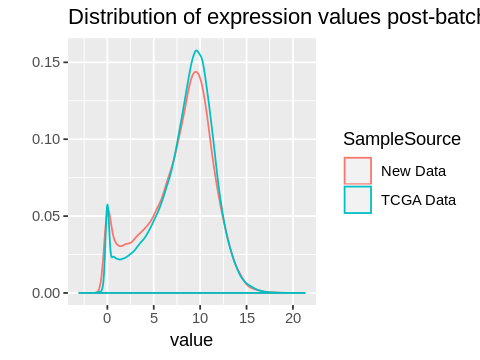

In [18]:
qplot(data=postCombatMelt, col=SampleSource, x=value, geom='density', main = 'Distribution of expression values post-batch-correction')

## Median center the joined data

In [19]:
# getting the medians of each gene
joinMeds <- apply(combat_edata, 1, median, na.rm=T)
# here we median center each gene
join_med_scaled <- sweep(combat_edata,1,joinMeds,'-')  


In [20]:
##
## Clean up time!
##
ls()
rm(dat, dat2idx, data.quantileExpressed, datlog2, datnorm, didx, newDat, newdatSamples, postCombat, postCombatMelt, preCombat, preCombatMelt, sampleIdx, sharedGenes, tcgaidx, tcgaSubsetSub)
gc()

library(pryr)
mem_used()

[1] "combat_edata"             "combatflag"              
 [3] "consensusEnsemble"        "dat"                     
 [5] "dat2idx"                  "data_genes_sigs12b"      
 [7] "data.quantileExpressed"   "datlog2"                 
 [9] "datnorm"                  "determineK"              
[11] "didx"                     "ensemblePredict"         
[13] "get.distances"            "ImmuneSigs_function"     
[15] "join_med_scaled"          "joinDat"                 
[17] "joinMeds"                 "mcentr"                  
[19] "modelEnsemble"            "mods2"                   
[21] "newDat"                   "newdatSamples"           
[23] "newDatSub"                "postCombat"              
[25] "postCombatMelt"           "preCombat"               
[27] "preCombatMelt"            "pred1"                   
[29] "predStrength"             "reportedScores"          
[31] "sample.scores"            "sampleIdx"               
[33] "sharedGenes"              "sigs1_2_eg2"             
[35] "sigs1_2_egIDs2"           "sigs1_2_names2"          
[37] "sigs1_2_type2"            "sigs12_module_weights"   
[39] "sigs12_module_weights_eg" "sigs12_weighted_means"   
[41] "sigs2"                    "tcgaidx"                 
[43] "tcgaSubset"               "tcgaSubsetSub"           
[45] "zscore.cols2"             "zscore.rows2"

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,3772499,201.5,6024137,321.8,8591118,458.9
Vcells,89433009,682.4,230478866,1758.5,210085170,1602.9


927 MB

## Compute the signature scores.


In [21]:

scores <- ImmuneSigs_function(join_med_scaled, sigs1_2_eg2,sigs12_weighted_means,
                                 sigs12_module_weights,sigs1_2_names2,sigs1_2_type2)


[1] "DONE MEAN"
[1] "DONE MEDIAN"
[1] "DONE WEIGHTED MEAN"
[1] "DONE MODULES"
[1] "DONE CHANG CORE"
[1] "DONE PCA"
[1] "DONE DONE"


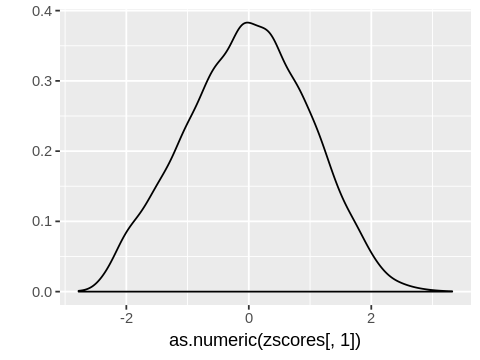

In [22]:
# and we subset the 5 scores used in clustering
idx <- c("LIexpression_score", "CSF1_response", "TGFB_score_21050467", "Module3_IFN_score", "CHANG_CORE_SERUM_RESPONSE_UP")
scores <- t(scores[idx,])
zscores <- zscore.cols2(scores)

qplot(as.numeric(zscores[,1]), geom='density')

## Classifying subtypes

In [23]:

  # make cluster calls using the models.
calls <- consensusEnsemble(mods2, zscores, 4, 128)
  

Iteration: 0 *** value: 8073.98


In [24]:
# get the top scoring cluster for each sample
maxcalls <- apply(calls$.Data, 1, function(a) which(a == max(a))[1])
names(maxcalls) <- rownames(scores)
  

In [25]:
# then we'll look at the new vs. old cluster calls for TCGA samples
sharedIDs <- intersect(reportedScores$AliquotBarcode, rownames(scores))
t1 <-table(Reported=as.numeric(reportedScores[sharedIDs, 'ClusterModel1']),
             NewCalls=as.numeric(maxcalls[sharedIDs]))
t1

        NewCalls
Reported    1    2    3    4    5    6
       1 2298   16   26   17   59    0
       2   11    4   13 2557    7    0
       3   13   44 2335    1    4    0
       4    7 1098   23   12    8   11
       5    0    9    0    0    0  376
       6    2    4   45    3  126    0

## Aligning the new calls

In [26]:
# then we can align the new calls to calls from the manuscript.
reported <- 1:6
optcalls <- 1:6

for (i in reported) {
    
    # for subtype i, where did most of the samples end up?
    j <- which(as.numeric(t1[i,]) == max(as.numeric(t1[i,])))
    # rename maxcall j <- i
    optcalls[i] <- j
}
  
print(optcalls)
  

[1] 1 4 3 2 6 5


In [27]:
  
# these are the re-mapped calls
alignedCalls <- sapply(maxcalls, function(a) which(a == optcalls)[1])


In [28]:
# make sure it works on the re-called TCGA data
t2 <-table(Reported=as.numeric(reportedScores[sharedIDs, 'ClusterModel1']),
             NewCalls=as.numeric(alignedCalls[sharedIDs]))

t2

        NewCalls
Reported    1    2    3    4    5    6
       1 2298   17   26   16    0   59
       2   11 2557   13    4    0    7
       3   13    1 2335   44    0    4
       4    7   12   23 1098   11    8
       5    0    0    0    9  376    0
       6    2    3   45    4    0  126

In [29]:
# assemble the results
jdx <- match(table=rownames(scores), x=colnames(newDatSub))  # index to new data scores
pcalls <- calls$.Data[jdx,]                            # get that table
rownames(pcalls) <- colnames(newDatSub)                      # name it from the new data
pcalls <- pcalls[,optcalls]
  
pcalls <- cbind(pcalls, data.frame(Call=alignedCalls[jdx]))  # bring in the aligned calls
pcalls <- cbind(pcalls, zscores[jdx,])                       # and the scores
    

In [30]:
head(pcalls)

,1,2,3,4,5,6,Call,LIexpression_score,CSF1_response,TGFB_score_21050467,Module3_IFN_score,CHANG_CORE_SERUM_RESPONSE_UP
XY1,0.0000000,0.0000000,0.0234375,0.7578125,0.1171875,0.1015625,4,-1.3070430,-0.7972310,-2.1110701,-1.3574503,-0.40072087
XY2,0.0078125,0.0000000,0.9375000,0.0000000,0.0078125,0.0468750,3,-0.8287012,-0.9581110,-0.8125681,-1.1205515,-1.27189094
XY3,0.0078125,0.0000000,0.5390625,0.3359375,0.0156250,0.1015625,3,-1.8441228,-1.7511525,-1.2926841,-1.0272892,-0.57171440
XY4,0.0156250,0.0078125,0.0000000,0.7656250,0.0468750,0.1640625,4,-1.4597400,-1.4366545,-1.5583687,-0.9422146,-0.06191644
XY5,0.0000000,0.0000000,0.0625000,0.7109375,0.1093750,0.1171875,4,-0.7388794,-0.2186962,-2.3626254,-0.6561893,-1.82942821
XY6,0.0078125,0.0156250,0.0000000,0.8046875,0.0000000,0.1718750,4,-1.8412376,-1.7937000,-1.5572605,-0.1607917,0.29395842


## Final results

In [31]:
finalResults <- list(AlignedCalls=alignedCalls[jdx], Table=t2, ProbCalls=pcalls)

In [38]:
# In the finalResults,
# $AlignedCalls are the immune subtypes - aligned with the TCGA manuscript
# $Table is the TCGA reported immune subtypes (on TCGA samples) compared to what we just computed
# $ProbCalls shows the probability of being in each subtype and signature scores, Call is the aligned call

In [33]:
# That's it!

In [42]:
load('../ExtraData//colnames_1to20_ebpp.rda')
rownames(reportedScores) <- str_replace_all(reportedScores$AliquotBarcode, pattern = '\\.', replacement = '-')


In [45]:
# cx is the vector of hidden TCGA barcodes
manuscriptCalls <- reportedScores[cx, 'ClusterModel1']

newCalls <- finalResults$AlignedCalls

In [50]:
table(Manuscript=manuscriptCalls, NEW_Calls=newCalls)

          NEW_Calls
Manuscript  2  3  4  6
         2  1  0  0  0
         3  0  4  0  0
         4  0  2 12  0
         6  0  0  0  1

In [ ]:
## So a couple of samples may be classified differently.
## There's naturally a little error involved, and that's expected.